In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version {}".format(tf.__version__))

TensorFlow version 1.14.0


In [5]:
mnist = tf.keras.datasets.mnist
(images_train, labels_train),(images_test, labels_test) = mnist.load_data()
class_names = ["zero","one","two","three","four","five","six","seven","eight","nine"]

In [6]:
print("Data type:", type(images_train))
print("Dataset shape:", (images_train.shape))

Data type: <class 'numpy.ndarray'>
Dataset shape: (60000, 28, 28)


In [7]:
print("Labels:", len(labels_train))
print("Possible values:", np.unique(labels_train))

Labels: 60000
Possible values: [0 1 2 3 4 5 6 7 8 9]


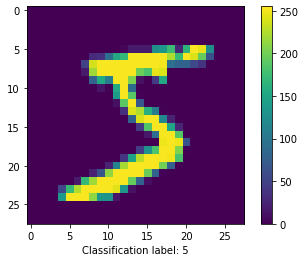

In [8]:
plt.figure()
plt.imshow(images_train[0])
plt.colorbar()
plt.grid(False)
plt.xlabel("Classification label: {}".format(labels_train[0]))
plt.show()

In [9]:
images_train = images_train / 255.0
images_test = images_test / 255.0

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0714 19:39:11.721603 139709329897280 deprecation.py:506] From /home/dimtass/miniconda3/envs/nn-env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.fit(images_train, labels_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.2120 - acc: 0.9349
Epoch 2/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1045 - acc: 0.9681
Epoch 3/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0811 - acc: 0.9754
Epoch 4/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0667 - acc: 0.9796
Epoch 5/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0565 - acc: 0.9819


In [88]:
test_loss, test_acc = model.evaluate(images_test, labels_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 33us/sample - loss: 0.1153 - acc: 0.9655
Test accuracy: 0.9655


In [89]:
model.summary()
loss, acc = model.evaluate(images_test, labels_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
__________________________________________________

In [90]:
model.save('mnist_keras.h5')

In [99]:
tflite_mnist_model = 'mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model_file('mnist_keras.h5')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open(tflite_mnist_model, "wb").write(tflite_model)

674288

In [100]:
interpreter = tf.lite.Interpreter(model_path=tflite_mnist_model)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: flatten_input
shape: [ 1 28 28]
type: <class 'numpy.float32'>

== Output details ==
name: dense_2/Softmax
shape: [ 1 10]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'flatten_input', 'index': 10, 'shape': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}

DUMP OUTPUT
{'name': 'dense_2/Softmax', 'index': 8, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}
